In [1]:

import wandb
import argparse
import yaml
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from src.models import DPTMultiviewDepth, SkipDPTMultiviewDepth
from src.dataloaders import RGBDepthDataset
from src.losses import virtual_normal_loss, midas_loss

import src.checkpoint as checkpoint
import src.utils as utils

import matplotlib.pyplot as plt

/home/aasadi/mutliview_robustness/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torchvision.transforms as transforms
import torch.nn.functional as F


def _gaussian_noise(x, scale=0.8, severity_idx=None):
    if severity_idx is not None:
        scale = [0.2, 0.5, 0.8, 1.1, 1.4][severity_idx]
    return torch.clip(x + torch.randn_like(x) * scale, min=-1, max=1)

def _gaussian_blur(x, sigma=8, severity_idx=None):
    if severity_idx is not None:
        sigma = [2, 5, 8, 11, 14][severity_idx]
    k = 4 * sigma + 1
    return transforms.functional.gaussian_blur(x, kernel_size=k, sigma=sigma)

def _fog_3d(x, depth, fog_strength=150, severity_idx=None):
    depth = depth/depth.max()
    if severity_idx is not None:
        fog_strength = [100, 125, 150, 175, 200][severity_idx]
    t = torch.exp(-fog_strength * depth)
    a = x.mean()
    return x * t + a * (1-t)

def _pixelate(x, resize=8, severity_idx=None):
    _, h, w = x.shape
    if severity_idx is not None:
        resize = [4, 6, 8, 10, 12][severity_idx]
    x = x[:,::resize,::resize]
    return F.interpolate(x[None,:], size=(h,w))[0]

def _identity(x, severity_idx=None):
    return x

In [3]:
torch.cuda.empty_cache()

In [4]:
class args:
    data_path= '/scratch/izar/aasadi/dataset/data/train'
    eval_data_path= '/scratch/izar/aasadi/dataset/data/val'
    batch_size= 2
    batch_size_eval= 1
    num_workers= 5
    
    corruptions= None
    eval_corruptions= None
    n_frames=4
    img_size= 384
    pos3d_depth= 5
    num_seq_knowledge_source=200
    small= True
    initialize_ks_with_pos_embed=False
    pos3d_encoding=True
    
    epochs= 100
    eval_freq= 500
    save_weight_freq= 20
    output_dir= '/scratch/izar/aasadi/results/skip-multiview-small'
    device= 'cuda:0'
    
    lr= 0.00001
    loss_fn= 'midas'


In [5]:
dataset = RGBDepthDataset(
                        root_dir=args.eval_data_path, 
                        n_frames=args.n_frames,
                        transform='identity',
                        image_size=args.img_size, 
                        depth_size=args.pos3d_depth, 
                        train_set=False,
                        small=args.small,
                    )


24646 24646 24646 24646


In [6]:
device = torch.device(args.device)

# define the model
model = SkipDPTMultiviewDepth.from_pretrained("Intel/dpt-large", 
                                          num_seq_knowledge_source=args.num_seq_knowledge_source,
                                          pos3d_encoding=args.pos3d_encoding,
                                          pos3d_depth=args.pos3d_depth,
                                          ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

start_epoch = checkpoint.load_checkpoint(args.output_dir, model, optimizer)

Some weights of SkipDPTMultiviewDepth were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['dpt.encoder.mid_ks_layer.5.attention.output.dense.weight', 'dpt.encoder.mid_ks_layer.2.attention.output.dense.bias', 'dpt.encoder.mid_ks_layer.0.attention.output.dense.bias', 'dpt.encoder.mid_ks_layer.1.attention.attention.key.weight', 'dpt.encoder.mid_ks_layer.3.output.dense.bias', 'dpt.encoder.mid_ks_layer.1.layernorm_after.weight', 'dpt.encoder.mid_ks_layer.1.attention.attention.key.bias', 'dpt.encoder.mid_ks_layer.1.output.dense.weight', 'dpt.encoder.mid_ks_layer.4.intermediate.dense.weight', 'dpt.pos3d_encoder.mlp_layer_2.weight', 'dpt.encoder.mid_ks_layer.4.attention.attention.query.weight', 'dpt.encoder.mid_ks_layer.5.layernorm_after.weight', 'dpt.pos3d_encoder.mlp_layer_1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'dpt.encoder.mid_ks_layer.2.output.dense.bias', 'dpt.encoder.mid_ks_layer.5.intermediate.dense.weight', '

ValueError: loaded state dict has a different number of parameter groups

In [ ]:
attn_read_write(attn):
    

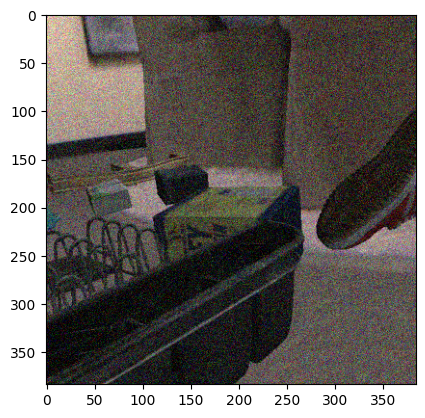

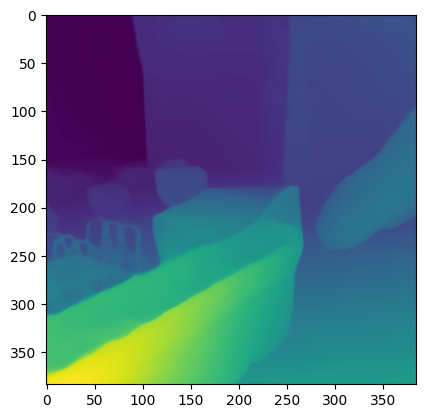

torch.Size([777, 777])


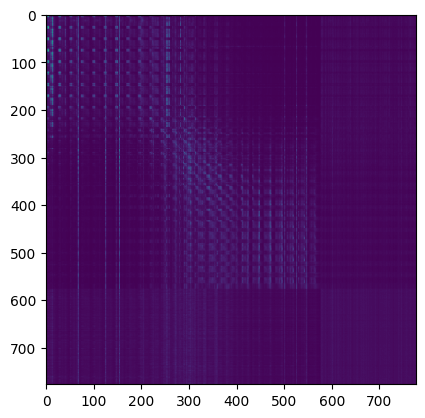

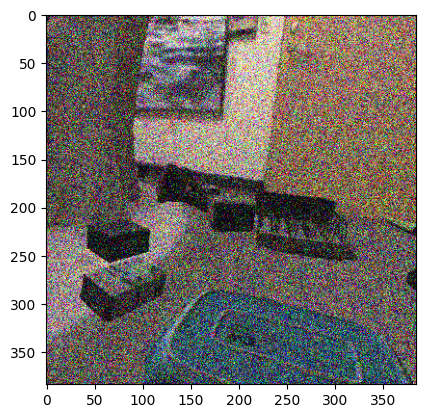

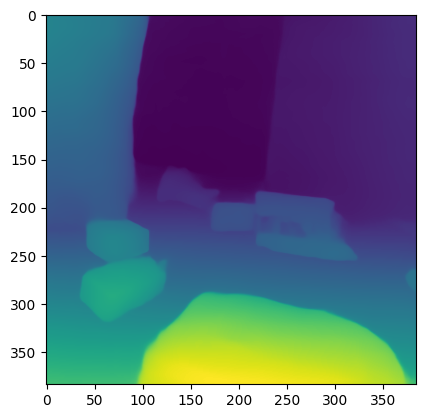

torch.Size([777, 777])


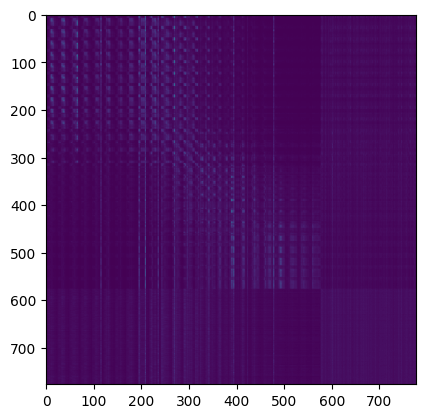

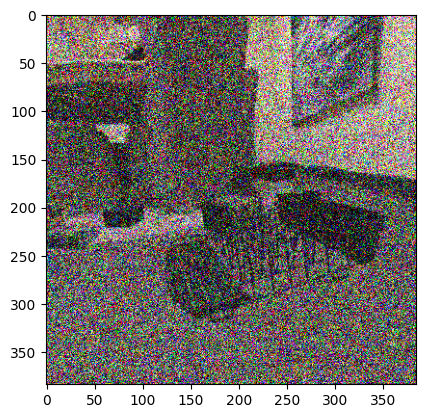

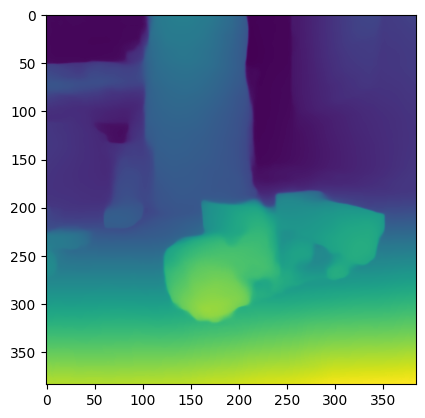

torch.Size([777, 777])


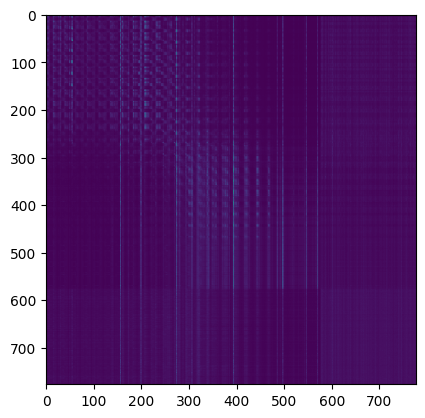

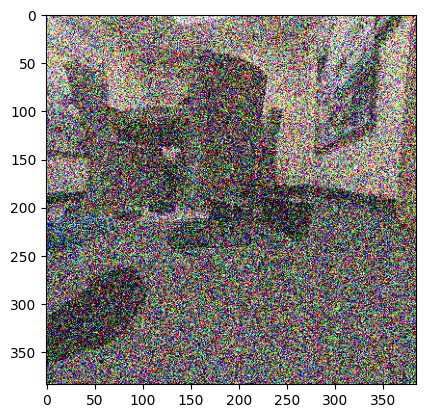

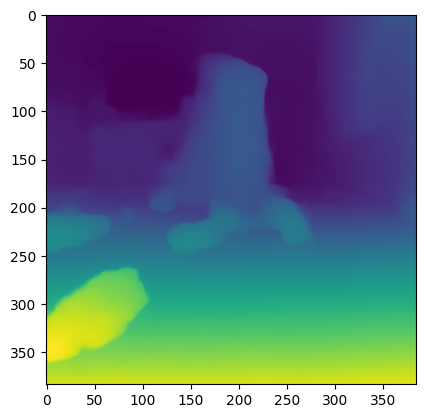

torch.Size([777, 777])


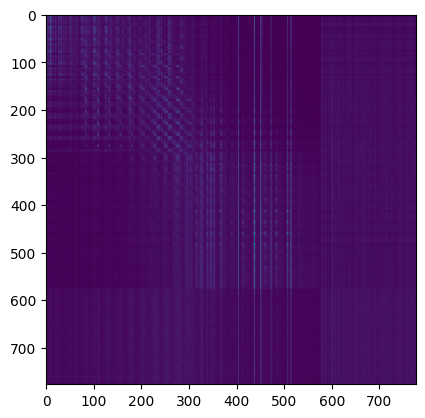

In [13]:
model.eval()
with torch.no_grad():
    for x, _, camera_frustum, _ in [dataset[1]]:

            x = x[None,:].to(device)
            camera_frustum = camera_frustum[None,:].to(device)

            ks = None

            for i in range(x.shape[1]):
                outputs = model(pixel_values=_gaussian_noise(x[:, i], severity_idx=i), knowledge_sources=ks, points3d=camera_frustum[:, i], output_attentions=True)
                ks = outputs["knowledge_sources"]
                predicted_depth = outputs["predicted_depth"]
                attn = outputs["attentions"]
                plt.imshow((_gaussian_noise(x[:, i], severity_idx=i)[0].permute(1,2,0).cpu() + 1)/2)
                plt.show()
                plt.imshow(predicted_depth[0].cpu())
                plt.show()
                print(attn[12][0].mean(dim=0).shape)
                plt.imshow(torch.exp(attn[12][0].mean(dim=0).cpu()))
                plt.show()
